In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/imp_doutorado/src/evolving_soda")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.MimoNonStationaryFtsPca import MimoNonStationaryFtsPca
from pyFTS.models.nonstationary import nsfts
from pyFTS.benchmarks import Measures
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import math


np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def sample_first_prows(data, perc):
    return data.head(int(len(data)*(perc)))

In [3]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [5]:
# convert series to supervised learning
def series_to_supervised_mimo(data, n_in, n_out, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(df.columns[j]+'(t)') for j in range(n_vars)]
		else:
			names += [(df.columns[j]+'%d(t+%d)' % (j, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
df = pd.read_csv('/home/hugo/projetos-doutorado/imp_doutorado/datasets/energydata_complete.csv', sep=',')
df = df.drop(labels=['date','rv1', 'rv2'], axis=1)
df = clean_dataset(df)
train = sample_first_prows(df,0.75)
test = df.iloc[max(train.index):]

cols = test.columns
list_cols = list(cols)
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']


In [7]:
# frame as supervised learning
reframed = series_to_supervised_mimo(df, 1, 1)
reframed.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8


In [8]:
cols = reframed.columns
cols

Index(['Appliances(t-1)', 'lights(t-1)', 'T1(t-1)', 'RH_1(t-1)', 'T2(t-1)',
       'RH_2(t-1)', 'T3(t-1)', 'RH_3(t-1)', 'T4(t-1)', 'RH_4(t-1)', 'T5(t-1)',
       'RH_5(t-1)', 'T6(t-1)', 'RH_6(t-1)', 'T7(t-1)', 'RH_7(t-1)', 'T8(t-1)',
       'RH_8(t-1)', 'T9(t-1)', 'RH_9(t-1)', 'T_out(t-1)', 'Press_mm_hg(t-1)',
       'RH_out(t-1)', 'Windspeed(t-1)', 'Visibility(t-1)', 'Tdewpoint(t-1)',
       'Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
       'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
       'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
       'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
       'Visibility(t)', 'Tdewpoint(t)'],
      dtype='object')

In [9]:
df_train = reframed.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
df_train

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t-1),RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1)
1,60.0,30.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,18.200000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000
2,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,18.200000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
3,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,18.200000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
4,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,18.100000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
5,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,18.100000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,90.0,0.0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.700000,45.626667,...,24.666667,50.445000,23.200000,46.7450,22.866667,755.2,55.333333,3.166667,22.833333,13.366667
19731,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,24.700000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19732,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,24.700000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19733,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,24.700000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667


In [10]:
train = sample_first_prows(df_train,0.75)
test = df_train.iloc[max(train.index):]


In [11]:
df_test = reframed.loc[:,'Appliances(t)':'Tdewpoint(t)']
ttrain = sample_first_prows(df_test,0.75)
ttest = df_test.iloc[max(ttrain.index):]

In [12]:
ttest

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
14801,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
14802,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
14803,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
14804,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
14805,90.0,0.0,22.426667,39.100000,22.290000,35.460000,25.633333,36.900000,22.5,34.700000,...,23.600000,37.860000,20.79,39.000000,8.500000,757.000000,61.000000,5.000000,40.000000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
19731,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
19732,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667
19733,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.662500,49.518750,23.20,46.817500,22.333333,755.200000,56.666667,3.833333,26.166667,13.233333


In [13]:
num_components_pca = 8
order_fts_model = 1
npart = 50
gamma = 0.1
fts_model = nsfts.NonStationaryFTS
memory_window_error = 3
steps_ahead = 1

mimo_pca_nsfts = MimoNonStationaryFtsPca(num_components_pca, order_fts_model, npart,
                                            gamma, fts_model, memory_window_error)

In [14]:
models, pca_data_train = mimo_pca_nsfts.run_train(train,'PCA')
forecast, pca_data_test = mimo_pca_nsfts.run_test(models,test,steps_ahead,'PCA')

In [15]:
df_forecast = pd.DataFrame(forecast,columns=list(ttest.columns))
print(df_forecast)

      Appliances(t)  lights(t)      T1(t)    RH_1(t)      T2(t)    RH_2(t)  \
0        271.550039   3.034579  22.587757  37.134102  21.976216  35.198711   
1        237.226415   2.406070  22.601229  36.809083  21.924503  35.027633   
2        274.852677   2.489397  22.651037  36.890526  21.923970  35.071705   
3        310.070800   2.712168  22.644583  37.165719  21.934497  35.211565   
4        205.204233   3.054117  22.730743  36.791686  21.978792  35.224261   
...             ...        ...        ...        ...        ...        ...   
4929     136.820090   3.428492  25.279802  46.300965  26.899548  40.988538   
4930     135.566684   3.386944  25.217263  46.127488  26.837286  40.840722   
4931     118.463557   2.333621  25.182054  45.918021  26.761987  40.733006   
4932     218.364260   9.769469  25.081834  46.672771  26.760003  41.070675   
4933     360.449512   7.652037  24.939155  47.278606  26.429375  41.642248   

          T3(t)    RH_3(t)      T4(t)    RH_4(t)  ...      T8(t

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

original = ttest['Appliances(t)']
forecast = df_forecast['Appliances(t)']

mae = mean_absolute_error(original,forecast)
#mse = mean_squared_error(original,forecast)
r2 = r2_score(original,forecast)
mape = mean_absolute_percentage_error(original,forecast)
rmse = mean_squared_error(original,forecast,squared=False)

print(mae)
#print(mse)
print(r2)
#print(mape)
print(rmse)

33.6936592021637
0.4871980801909236
63.21946584093434


In [17]:
#print(np. isnan(df_forecast['RH_1']))

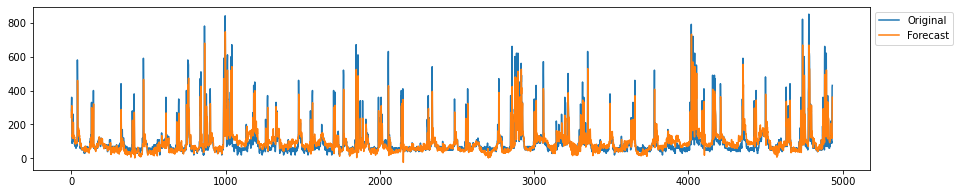

In [18]:
appliances = ttest['Appliances(t)'].reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(appliances['Appliances(t)'], label='Original')
ax.plot(df_forecast['Appliances(t)'], label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [19]:
num_components_pca = 6
order_fts_model = 1
npart = 50
gamma = 0.1
fts_model = nsfts.NonStationaryFTS
memory_window_error = 3
steps_ahead = 1

mimo_kpca_nsfts = MimoNonStationaryFtsPca(num_components_pca, order_fts_model, npart,
                                            gamma, fts_model, memory_window_error)

In [20]:
kmodels, kpca_data_train = mimo_kpca_nsfts.run_train(train,'KPCA')
kforecast, kpca_data_test = mimo_kpca_nsfts.run_test(models,test,steps_ahead,'KPCA')

In [21]:
kdf_forecast = pd.DataFrame(kforecast,columns=list(ttest.columns))
print(kdf_forecast)

      Appliances(t)  lights(t)      T1(t)    RH_1(t)      T2(t)    RH_2(t)  \
0        245.449243  -3.581349  22.815632  40.211754  22.734217  37.646847   
1        199.473925  -6.266582  23.167704  37.337504  22.889368  34.925383   
2        252.378991  -5.628184  23.710154  38.578223  23.501426  35.931870   
3        285.930205  -6.128569  23.782977  37.794756  23.209691  35.581402   
4        160.685577  -4.300503  23.361092  41.276039  22.816859  39.440856   
...             ...        ...        ...        ...        ...        ...   
4929      41.553055  -4.594788  25.917221  43.306974  25.559280  40.079732   
4930      47.999309  -4.867372  26.044684  43.020747  25.385301  39.849218   
4931      37.425565  -4.914278  25.974308  42.787282  25.178982  39.829158   
4932     222.622115   5.351900  26.428225  45.480937  26.175255  41.977710   
4933     370.362289   5.101834  26.757022  47.561863  26.559204  43.498387   

          T3(t)    RH_3(t)      T4(t)    RH_4(t)  ...      T8(t

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

koriginal = ttest['RH_out(t)']
kforecast = kdf_forecast['RH_out(t)']

mae = mean_absolute_error(koriginal,kforecast)
#mse = mean_squared_error(original,forecast)
r2 = r2_score(koriginal,kforecast)
#mape = mean_absolute_percentage_error(koriginal,kforecast)
rmse = mean_squared_error(koriginal,kforecast,squared=False)

print(mae)
#print(mse)
print(r2)
#print(mape)
print(rmse)

5.085242363966394
0.8812364014865912
6.296439448040343


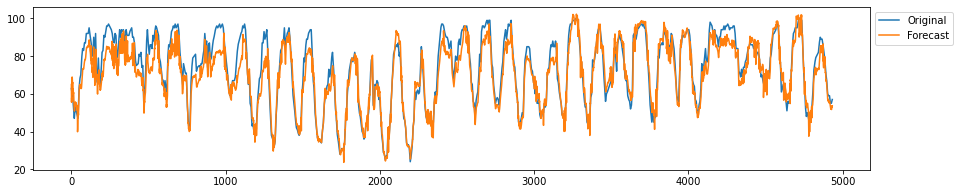

In [23]:
kappliances = ttest['RH_out(t)'].reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(kappliances['RH_out(t)'], label='Original')
ax.plot(kdf_forecast['RH_out(t)'], label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [55]:
reframed.columns

Index(['Appliances(t-1)', 'lights(t-1)', 'T1(t-1)', 'RH_1(t-1)', 'T2(t-1)',
       'RH_2(t-1)', 'T3(t-1)', 'RH_3(t-1)', 'T4(t-1)', 'RH_4(t-1)', 'T5(t-1)',
       'RH_5(t-1)', 'T6(t-1)', 'RH_6(t-1)', 'T7(t-1)', 'RH_7(t-1)', 'T8(t-1)',
       'RH_8(t-1)', 'T9(t-1)', 'RH_9(t-1)', 'T_out(t-1)', 'Press_mm_hg(t-1)',
       'RH_out(t-1)', 'Windspeed(t-1)', 'Visibility(t-1)', 'Tdewpoint(t-1)',
       'Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
       'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
       'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
       'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
       'Visibility(t)', 'Tdewpoint(t)'],
      dtype='object')

In [ ]:
# df_forecast.rename(columns = {'Appliances(t-1)': 'Appliances(t)', 
#                               'lights(t-1)':'lights(t)', 'T1(t-1)':'T1(t)', 
#                               'RH_1(t-1)':'RH_1(t)', 'T2(t-1)':'T2(t)',
#                               'RH_2(t-1)':'RH_2(t)', 'T3(t-1)':'T3(t)', 
#                               'RH_3(t-1)':'RH_3(t)', 'T4(t-1)':'T4(t)', 
#                               'RH_4(t-1)':'RH_4(t)', 'T5(t-1)':'T5(t)',
#                               'RH_5(t-1)':'RH_5(t)', 'T6(t-1)':'T6(t)', 
#                               'RH_6(t-1)':'RH_6(t)', 'T7(t-1)':'T7(t)', 
#                               'RH_7(t-1)':'RH_7(t)', 'T8(t-1)':'T8(t)',
#                               'RH_8(t-1)':'RH_8(t)', 'T9(t-1)':'T9(t)', 
#                               'RH_9(t-1)':'RH_9(t)', 'T_out(t-1)':'T_out(t)', 
#                               'Press_mm_hg(t-1)':'Press_mm_hg(t)',
#                               'RH_out(t-1)':'RH_out(t)', 'Windspeed(t-1)':'Windspeed(t)', 
#                               'Visibility(t-1)':'Visibility(t)','Tdewpoint(t-1)':'Tdewpoint(t)'}, 
#                                inplace = True)

In [56]:
# df_forecats_coluns = ['Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
#        'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
#        'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
#        'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
#        'Visibility(t)', 'Tdewpoint(t)']

In [105]:
def sliding_window_pca(data,n_windows,train_size,steps_ahead,transformation):

    result = {
         "window": [],
         "rmse": [],
         "nrmse": [],
         "mae": [],
         "r2": [],
         "variable":[]
    }
    
    final_result = {
         "window": [],
         "rmse": [],
         "nrmse": [],
         "mae": [],
         "r2": [],
         "variable":[]
    }

    tam = len(data)
    n_windows = 30
    windows_length = math.floor(tam / n_windows)
    for ct, ttrain, ttest in Util.sliding_window(data, windows_length, train_size, inc=1):
        if len(ttest) > 0:
            
            print('-' * 20)
            print(f'training window {(ct)}')
            
            df_train = ttrain.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
            df_test = ttest.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
            df_original = ttest.loc[:,'Appliances(t)':'Tdewpoint(t)']
            
            models, data_train = mimo_kpca_nsfts.run_train(df_train,transformation)
            forecast, data_test = mimo_kpca_nsfts.run_test(models,df_test,steps_ahead,transformation)
            
            
            df_forecats_columns = ['Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
                                   'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
                                   'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
                                   'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
                                   'Visibility(t)', 'Tdewpoint(t)']
            columns = list(df_forecats_columns)
            df_forecast = pd.DataFrame(forecast,columns=columns)
            
            for col in columns:  
                original = df_original[col].values
                forecast = df_forecast[col].values
                original = original[:len(original)-1]
                forecast = forecast[1:]
                
                #print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics for variable: " + col)
                mae = mean_absolute_error(original,forecast)
                r2 = r2_score(original,forecast)
                rmse = mean_squared_error(original,forecast,squared=False)
                nrmse = cal_nrmse(rmse, original)

                result["rmse"].append(rmse)
                result["nrmse"].append(nrmse)
                result["mae"].append(mae)
                result["r2"].append(r2)
                result["window"].append(ct)
                result["variable"].append(col)
                
#                 fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
#                 ax.plot(original, label='Original')
#                 ax.plot(forecast, label='Forecast')
#                 handles, labels = ax.get_legend_handles_labels()
#                 lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
#                 plt.show()
        
    measures = pd.DataFrame(result)
    return measures

In [106]:
# agr = kpca_result.groupby("variable")
# agrupado = agr.get_group('Appliances(t)')
# test = statistics.mean(agrupado.loc[:,'rmse'])
# test

In [107]:
# columns = list(df_test.columns)
# columns

## Sliding Window: MIMO KPCA-NSFTS

In [108]:
num_components_pca = 3
order_fts_model = 1
npart = 50
gamma = 0.1
fts_model = nsfts.NonStationaryFTS
memory_window_error = 3
steps_ahead = 1

mimo_kpca_nsfts = MimoNonStationaryFtsPca(num_components_pca, order_fts_model, npart,
                                            gamma, fts_model, memory_window_error)

In [109]:
kpca_result =  sliding_window_pca(data=reframed,n_windows=30,train_size=0.75,steps_ahead=1,transformation='KPCA')

--------------------
training window 0
--------------------
training window 657
--------------------
training window 1314
--------------------
training window 1971
--------------------
training window 2628
--------------------
training window 3285
--------------------
training window 3942
--------------------
training window 4599
--------------------
training window 5256
--------------------
training window 5913
--------------------
training window 6570
--------------------
training window 7227
--------------------
training window 7884
--------------------
training window 8541
--------------------
training window 9198
--------------------
training window 9855
--------------------
training window 10512
--------------------
training window 11169
--------------------
training window 11826
--------------------
training window 12483
--------------------
training window 13140
--------------------
training window 13797
--------------------
training window 14454
--------------------
training w

In [110]:
columns = list(df_test.columns)

final_result = {
    "variable": [],
    "rmse": [],
    "nrmse": [],
    "mae": [],
    "r2": []
}

measures = kpca_result
var = measures.groupby("variable")

for col in columns:
    
    var_agr = var.get_group(col)
           
    rmse = statistics.mean(var_agr.loc[:,'rmse'])
    nrmse = statistics.mean(var_agr.loc[:,'nrmse'])
    mae = statistics.mean(var_agr.loc[:,'mae'])
    r2 = statistics.mean(var_agr.loc[:,'r2'])

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    final_result["nrmse"].append(nrmse)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
        
    #print(f'Results: {(col,rmse,mae,r2)}')
        
        
final_measures_kpca = pd.DataFrame(final_result) 



In [111]:
print("Statistics MIMO KPCA-NSFTS(test): ")
final_measures_kpca

Statistics MIMO KPCA-NSFTS(test): 


,variable,rmse,nrmse,mae,r2
0,Appliances(t),2.636213,0.005470,1.974026,0.998827
1,lights(t),0.270729,NaN,0.203696,0.998545
2,T1(t),0.035507,0.018444,0.026519,0.995894
3,RH_1(t),0.081723,0.010780,0.063141,0.996863
4,T2(t),0.074308,0.018740,0.055924,0.995731
5,RH_2(t),0.132855,0.015545,0.101165,0.996367
6,T3(t),0.022069,0.012402,0.016985,0.997282
7,RH_3(t),0.056860,0.013078,0.042382,0.996660
8,T4(t),0.030616,0.016059,0.023047,0.996165
9,RH_4(t),0.067794,0.014390,0.051148,0.996194


## Sliding Window: MIMO PCA-NSFTS

In [112]:
num_components_pca = 10
order_fts_model = 1
npart = 50
gamma = 0.1
fts_model = nsfts.NonStationaryFTS
memory_window_error = 3
steps_ahead = 1

mimo_kpca_nsfts = MimoNonStationaryFtsPca(num_components_pca, order_fts_model, npart,
                                            gamma, fts_model, memory_window_error)

In [113]:
pca_result =  sliding_window_pca(data=reframed,n_windows=30,train_size=0.75,steps_ahead=1,transformation='PCA')

--------------------
training window 0
--------------------
training window 657
--------------------
training window 1314
--------------------
training window 1971
--------------------
training window 2628
--------------------
training window 3285
--------------------
training window 3942
--------------------
training window 4599
--------------------
training window 5256
--------------------
training window 5913
--------------------
training window 6570
--------------------
training window 7227
--------------------
training window 7884
--------------------
training window 8541
--------------------
training window 9198
--------------------
training window 9855
--------------------
training window 10512
--------------------
training window 11169
--------------------
training window 11826
--------------------
training window 12483
--------------------
training window 13140
--------------------
training window 13797
--------------------
training window 14454
--------------------
training w

In [114]:
columns = list(df_test.columns)

final_result = {
    "variable": [],
    "rmse": [],
    "nrmse": [],
    "mae": [],
    "r2": []
}

measures = pca_result
var = measures.groupby("variable")

for col in columns:
    
    var_agr = var.get_group(col)
           
    rmse = statistics.mean(var_agr.loc[:,'rmse'])
    nrmse = statistics.mean(var_agr.loc[:,'nrmse'])
    mae = statistics.mean(var_agr.loc[:,'mae'])
    r2 = statistics.mean(var_agr.loc[:,'r2'])

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    final_result["nrmse"].append(nrmse)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
        
    #print(f'Results: {(col,rmse,mae,r2)}')
        
        
final_measures_pca = pd.DataFrame(final_result) 

print("Statistics MIMO PCA-NSFTS(test): ")
final_measures_pca

Statistics MIMO PCA-NSFTS(test): 


,variable,rmse,nrmse,mae,r2
0,Appliances(t),25.939701,0.049361,19.406798,0.907447
1,lights(t),2.179539,inf,1.649635,0.843304
2,T1(t),0.093526,0.047207,0.069880,0.972665
3,RH_1(t),0.404584,0.049555,0.284784,0.930913
4,T2(t),0.169414,0.044256,0.127167,0.977171
5,RH_2(t),0.350736,0.048013,0.268093,0.960741
6,T3(t),0.104625,0.054630,0.080605,0.948116
7,RH_3(t),0.238898,0.054856,0.181486,0.941471
8,T4(t),0.121201,0.056158,0.092069,0.954997
9,RH_4(t),0.229015,0.050217,0.173630,0.950171
